In [1]:
# 파일 및 경로 처리
import os                                # OS 관련 기능 (파일, 디렉토리 등)
from glob import glob                    # 특정 패턴에 맞는 파일 경로 리스트 추출

# 시각화 및 데이터 분석
import matplotlib.pyplot as plt          # 데이터 시각화 (그래프 등)
import seaborn as sns                    # 고급 통계 시각화 (히트맵 등)
import pandas as pd                      # 데이터프레임 기반 데이터 분석
import numpy as np                       # 수치 연산 및 배열 처리

# 이미지 처리
import cv2                               # OpenCV - 이미지 및 영상 처리
from PIL import Image, ImageEnhance, ImageFilter  # PIL - 이미지 열기/편집, 필터 적용 등

# PyTorch 관련
import torch                             # PyTorch 기본 라이브러리
import torch.nn as nn                    # 신경망 레이어, 손실 함수 등
import torch.optim as optim              # 최적화 알고리즘 (SGD, Adam 등)
from torch.utils.data import Dataset, DataLoader, random_split  # 데이터셋/로더 유틸
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchinfo import summary

# 모델 학습/평가용 데이터 분할
from sklearn.model_selection import train_test_split  # 데이터셋 train/val/test 분할
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# TensorFlow / Keras 관련
from tensorflow import keras                         # TensorFlow에서 Keras 모듈 사용
from keras.models import Model, load_model           # 모델 생성 및 저장된 모델 불러오기
from keras.applications.vgg16 import VGG16           # 사전 학습된 VGG16 모델 불

import warnings
warnings.filterwarnings('ignore')

## 기본 설정하기

In [4]:
# 현재 실행 환경에서 GPU가 사용 가능한지 확인한 후, 그에 맞는 장치를 선택하기 위함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
# 경로 설정
train_dir = './data/chest_xray/train/'
train_normal_dir = os.path.join(train_dir, 'normal')
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')

val_dir = './data/chest_xray/val/'
val_normal_dir = os.path.join(val_dir, 'normal')
val_pneumonia_dir = os.path.join(val_dir, 'pneumonia')

test_dir = './data/chest_xray/test/'
test_normal_dir = os.path.join(test_dir, 'normal')
test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')

In [6]:
Image_size = [224,224]
Batch_size = 32
Epochs = 5

In [7]:
Classes = os.listdir(train_dir)
n_classes = len(Classes)

In [8]:
print(f"Class : {Classes}\nlength : {n_classes}")

Class : ['.DS_Store', 'PNEUMONIA', 'NORMAL']
length : 3


In [9]:
# 숨김 파일 제외하고 출력
Classes = [folder for folder in os.listdir(train_dir) if not folder.startswith('.')]
n_classes = len(Classes)

print(f"Class : {Classes}\nlength : {n_classes}")

Class : ['PNEUMONIA', 'NORMAL']
length : 2


## 데이터 로드 및 증강

In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

In [12]:
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

## 데이터셋 및 데이터로더 정의

In [14]:
train_dataset = ImageFolder(train_dir, transform = train_transform)
val_dataset = ImageFolder(val_dir, transform = val_test_transform)
test_dataset = ImageFolder(test_dir, transform = val_test_transform)

In [15]:
train_loader = DataLoader(train_dataset, batch_size = Batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size = Batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = Batch_size, shuffle=False, num_workers=2)

# VGG16 / BCEWithLogitsLoss()

## VGG16 모델 불러오기 및 수정

In [17]:
model = models.vgg16(pretrained=True)

In [18]:
# conv5_1 이후만 학습 가능하게 설정 (VGG16의 마지막 conv block)
for name, param in model.features.named_parameters():
    if '28' in name or '30' in name:  # 마지막 블록의 layer index
        param.requires_grad = True

In [19]:
#for param in model.parameters():
#    param.requires_grad = False

Add on Custom Classifier We'll train a classifier consisting of the following layers

- Fully connected with ReLU activation (n_inputs, 256)
- Dropout with 40% chance of dropping
- Fully connected with log softmax output (256, n_classes)

In [21]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [22]:
# model.classifier[6] = nn.Linear(4096,1)

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
135,309,890 training parameters.


In [ ]:
def get_pretrained_model(model_name):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False  # 전체 freeze

        n_inputs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 1))  # 이 경우는 binary classification
    return model

In [154]:
# 모델 이름을 받아 해당하는 사전 학습된 모델을 반환한다.
# 현재 vgg16 또는 resnet50만 지원한다.
def get_pretrained_model(model_name):
    """VGG16 모델을 불러와서 마지막 레이어를 다중 클래스 분류용으로 수정한 후, CrossEntropyLoss에 맞게 설정한다.

    Params
    -------
    model_name (str): 'vgg16' (현재 vgg16만 지원)
    n_classes (int): 분류할 클래스의 개수

    Return
    --------
    model (PyTorch model): 수정된 VGG16 모델
    """
    if model_name == 'vgg16':     # model_name (str): 'vgg16' 또는 'resnet50' 중 하나를 전달
        model = models.vgg16(pretrained=True)   # pretrained=True로 설정하여 ImageNet 데이터셋으로 학습된 가중치를 로드

        # 레이어 고정 (Feature extractor로 사용)
        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False

        # 분류기 수정
        n_inputs = model.classifier[6].in_features    # 기존 분류기의 마지막 레이어(input layer)의 입력 뉴런 수를 가져온다.

        # Add on classifier
        # VGG16의 마지막 classifier 레이어를 교체
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 1))  # LogSoftmax(dim=1)는 다중 클래스 분류를 위한 로그 확률 출력

    return model

In [ ]:
#model = get_pretrained_model('vgg16').to(device)
#summary(model, input_size=(3, 224, 224), batch_size=Batch_size,  device=device)

In [25]:
model = get_pretrained_model('vgg16').to(device)
summary(model, input_size=(Batch_size, 3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 1]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]   

**(에러 발생)** : Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

**(문제 원인)** : batch_size를 인자로 넘김 → forward()에서 에러 발생

**(해결 방안)** : input_size=(배치, 채널, 높이, 너비) 형식으로 batch_size를 포함시키기


In [27]:
# Mapping of Classes to Indexes
model.class_to_idx = train_dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'NORMAL'), (1, 'PNEUMONIA')]

In [28]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([1, 256])
torch.Size([1])


## 손실 함수 및 최적화 알고리즘 정의

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## 학습 및 검증 함수

In [32]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train() 
        running_loss, correct, total = 0.0, 0, 0     # 손실 및 정확도 계산을 위한 변수 초기화

        # 미니 배치 학습 루프
        for images, labels in train_loader:
            images = images.to(device)
            # BCE 손실함수는 float타입의 (B,1)형태인 라벨을 요구하기에 .unsqueeze(1)를 이용하여 (B,)→(B, 1)차원으로 맞췄다.
            labels = labels.float().unsqueeze(1).to(device)

            # 순전파, 손실 계산, 역전파, 가중치 업데이트
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # 훈련 정확도 및 손실 누적
            running_loss += loss.item()    # 현재 배치 손실값을 숫자로 추출해 누적
            preds = (torch.sigmoid(outputs) > 0.5).float()  # threshold:0.5
            correct += (preds == labels).sum().item()    # 예측값(preds)과 실제값(labels)을 비교해서 맞춘 개수 카운팅
            total += labels.size(0)

        # 학습 결과 출력
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        print(f"[Epoch {epoch+1}] | Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}",flush=True)
        print(f"outputs: {outputs.shape}, labels: {labels.shape}, preds: {preds.shape}")

        # 모델 검증
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # 검증 결과 출력
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}\n",flush=True)
        

## 학습

In [34]:
train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=Epochs, device=device)

[Epoch 1] | Train Loss: 0.2845 | Accuracy: 0.8840
outputs: torch.Size([32, 1]), labels: torch.Size([32, 1]), preds: torch.Size([32, 1])
Validation Loss: 0.3091, Accuracy: 0.8750

[Epoch 2] | Train Loss: 0.1950 | Accuracy: 0.9199
outputs: torch.Size([32, 1]), labels: torch.Size([32, 1]), preds: torch.Size([32, 1])
Validation Loss: 0.2800, Accuracy: 0.9375

[Epoch 3] | Train Loss: 0.1823 | Accuracy: 0.9266
outputs: torch.Size([32, 1]), labels: torch.Size([32, 1]), preds: torch.Size([32, 1])
Validation Loss: 0.2967, Accuracy: 0.9375

[Epoch 4] | Train Loss: 0.1759 | Accuracy: 0.9294
outputs: torch.Size([32, 1]), labels: torch.Size([32, 1]), preds: torch.Size([32, 1])
Validation Loss: 0.2280, Accuracy: 0.9375

[Epoch 5] | Train Loss: 0.1682 | Accuracy: 0.9339
outputs: torch.Size([32, 1]), labels: torch.Size([32, 1]), preds: torch.Size([32, 1])
Validation Loss: 0.2194, Accuracy: 0.9375



## 평가 함수 정의

In [70]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            probs = torch.sigmoid(outputs)  # 확률값

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # 평가지표 계산
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy : {acc}\nPrecision : {precision}\nRecall : {recall}\nf1-score : {f1}")

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return y_true, y_pred, y_scores

Accuracy : 0.8621794871794872
Precision : 0.8979057591623036
Recall : 0.8794871794871795
f1-score : 0.88860103626943


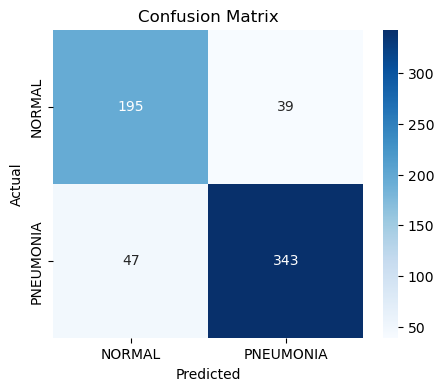

In [72]:
y_true, y_pred, y_scores = evaluate_model(model, test_loader, device)

In [75]:
# ROC Curve 시각화
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.7)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

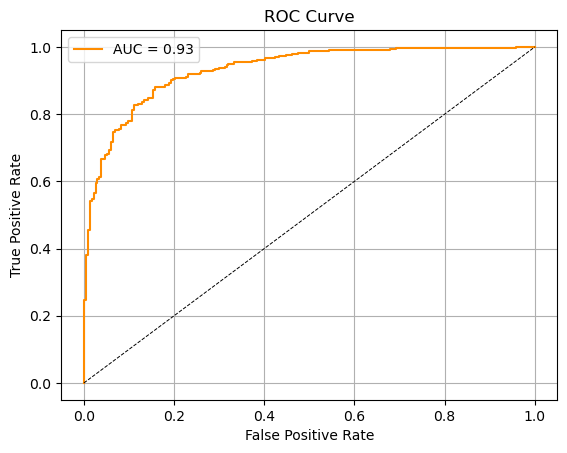

In [76]:
plot_roc_curve(y_true, y_scores)

In [77]:
# Precision-Recall Curve 및 F1-score 출력
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

def plot_PR_and_classification_report(y_true, y_pred, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}", color='green')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

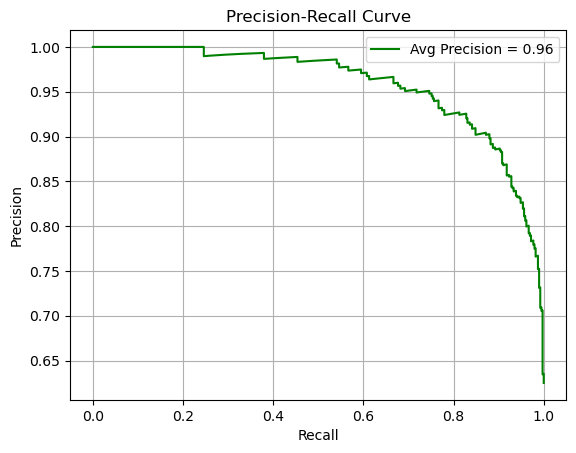

Classification Report:
              precision    recall  f1-score   support

           0     0.8058    0.8333    0.8193       234
           1     0.8979    0.8795    0.8886       390

    accuracy                         0.8622       624
   macro avg     0.8518    0.8564    0.8540       624
weighted avg     0.8634    0.8622    0.8626       624



In [78]:
plot_PR_and_classification_report(y_true, y_pred, y_scores)

## 이미지 불러오고 예측하기

In [133]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch

def predict_and_show_from_folder_with_names(model, folder_path, device, transform, idx_to_class):
    """
    폴더 안의 모든 이미지를 예측하고 이미지명과 함께 결과를 시각화합니다.

    Params
    -------
    model: 학습된 모델
    folder_path (str): 이미지가 들어 있는 폴더 경로
    device: 'cuda' or 'cpu'
    transform: torchvision.transforms.Compose
    idx_to_class: index → class 이름 dict
    """
    model.eval()

    # 폴더 내의 모든 이미지 파일 경로 가져오기
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    
    num_images = len(image_paths)
    rows = num_images // 4 + (1 if num_images % 4 != 0 else 0)

    plt.figure(figsize=(15, rows * 5))

    for i, img_path in enumerate(image_paths):
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            prob = torch.sigmoid(output).item()
            pred = int(prob > 0.5)
            class_name = idx_to_class[pred]

        # 이미지명 추출
        image_name = os.path.basename(img_path)

        # 시각화
        plt.subplot(rows, 3, i + 1)
        plt.imshow(image)
        plt.title(f"{image_name}\n{class_name} ({prob:.2f})")
        plt.axis('off')

    plt.tight_layout(pad=6)
    plt.show()

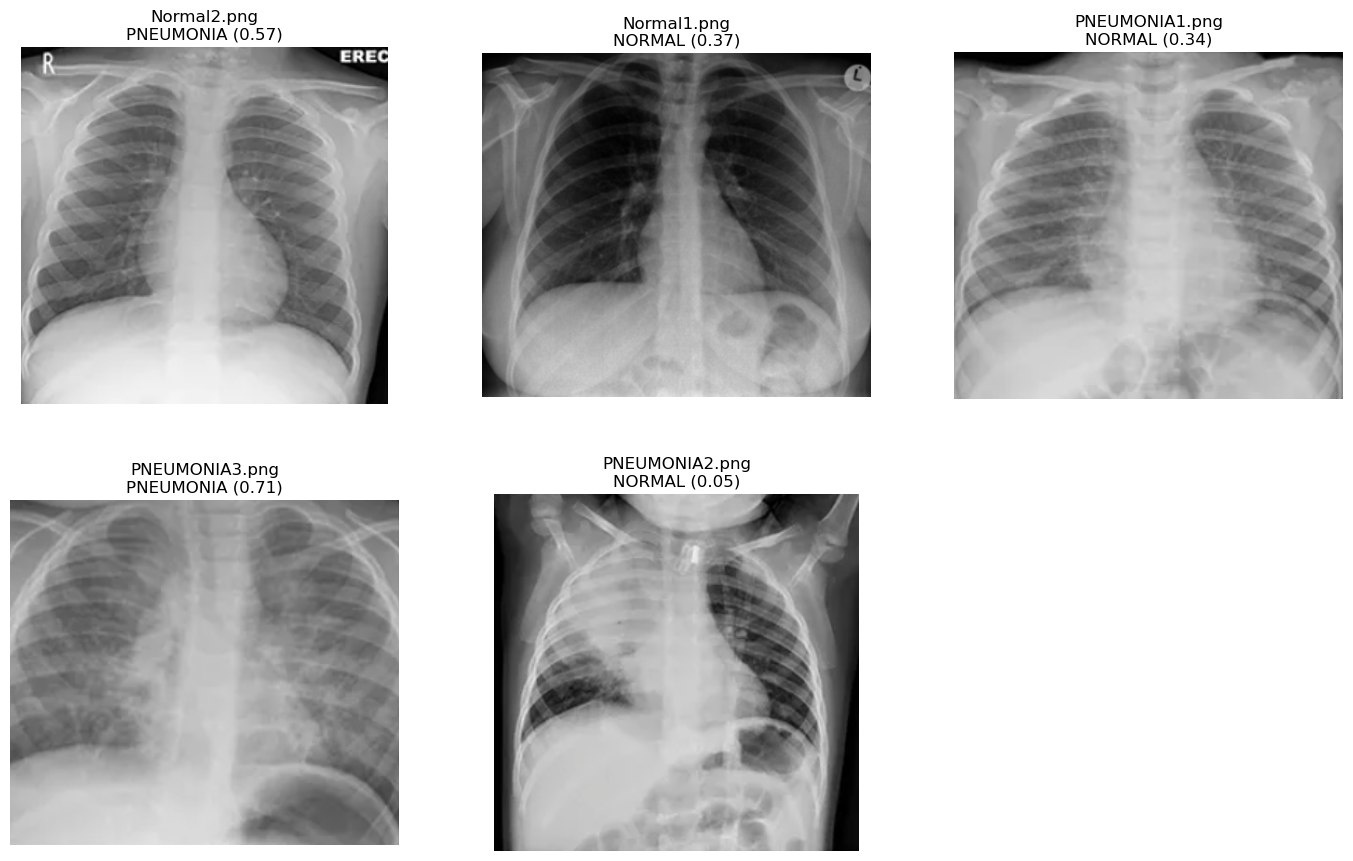

In [135]:
folder_path = "./data/chest_xray/sample"
predict_and_show_from_folder_with_names(model, folder_path, device, val_test_transform, model.idx_to_class)

# VGG16 / CrossEntropyLoss()

In [ ]:
def get_pretrained_model_CEL(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.classifier[6].in_features

        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256,2))

    return model

In [164]:
def get_pretrained_model_CEL(model_name):
    """VGG16 모델을 불러와서 마지막 레이어를 다중 클래스 분류용으로 수정한 후, CrossEntropyLoss에 맞게 설정한다.

    Params
    -------
    model_name (str): 'vgg16' (현재 vgg16만 지원)
    n_classes (int): 분류할 클래스의 개수

    Return
    --------
    model (PyTorch model): 수정된 VGG16 모델
    """
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # 레이어 고정 (Feature extractor로 사용)
        for param in model.parameters():
            param.requires_grad = False

        # 분류기 수정
        n_inputs = model.classifier[6].in_features  # 기존 분류기의 마지막 레이어의 입력 뉴런 수를 가져온다.

        # Add on classifier
        # VGG16의 마지막 classifier 레이어를 수정하여 n_classes개의 출력값을 만들도록 한다.
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256,2))  # nn.Linear(256, n_classes)) : 마지막 레이어는 n_classes로 수정

    return model

In [166]:
model_vgg16_CEL = get_pretrained_model_CEL('vgg16').to(device)
summary(model_vgg16_CEL, input_size=(Batch_size, 3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]   

In [167]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [168]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # 미니 배치 학습 루프
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)  # CrossEntropyLoss는 레이블이 0, 1, 2 형태의 클래스 인덱스를 요구함

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # 클래스 예측
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # 학습 결과 출력
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        print(f"[Epoch {epoch+1}] | Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}", flush=True)

        # 모델 검증
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # 검증 결과 출력
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}\n", flush=True)

In [169]:
# 모델을 학습할 때:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vgg16_CEL = model_vgg16_CEL.to(device)

train_model(model_vgg16_CEL, train_loader, val_loader, loss_fn, optimizer, epochs=5, device=device)

[Epoch 1] | Train Loss: 0.6560 | Accuracy: 0.6338
Validation Loss: 0.6958, Accuracy: 0.6250

[Epoch 2] | Train Loss: 0.6549 | Accuracy: 0.6267
Validation Loss: 0.6958, Accuracy: 0.6250

[Epoch 3] | Train Loss: 0.6572 | Accuracy: 0.6214
Validation Loss: 0.6958, Accuracy: 0.6250

[Epoch 4] | Train Loss: 0.6559 | Accuracy: 0.6331
Validation Loss: 0.6958, Accuracy: 0.6250

[Epoch 5] | Train Loss: 0.6561 | Accuracy: 0.6346
Validation Loss: 0.6958, Accuracy: 0.6250



In [178]:
def evaluate_model_CEL(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)  # 라벨은 정수형 (0 or 1)

            outputs = model(images)  # 로짓 (B, 2)
            probs = torch.softmax(outputs, dim=1)  # 클래스별 확률
            preds = torch.argmax(probs, dim=1)     # 확률 최대값 위치가 예측 클래스

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs[:, 1].cpu().numpy())  # 'PNEUMONIA' 클래스 확률 저장

    # 평가지표 출력
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Evaluation Metrics (CrossEntropy)")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")

    # 혼동행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NORMAL", "PNEUMONIA"],
                yticklabels=["NORMAL", "PNEUMONIA"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_scores


Evaluation Metrics (CrossEntropy)
Accuracy  : 0.6186
Precision : 0.6545
Recall    : 0.8256
F1 Score  : 0.7302


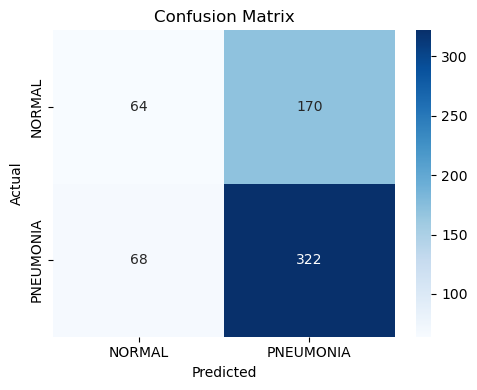

In [180]:
y_true, y_pred, y_scores = evaluate_model_CEL(model_vgg16_CEL, test_loader, device)

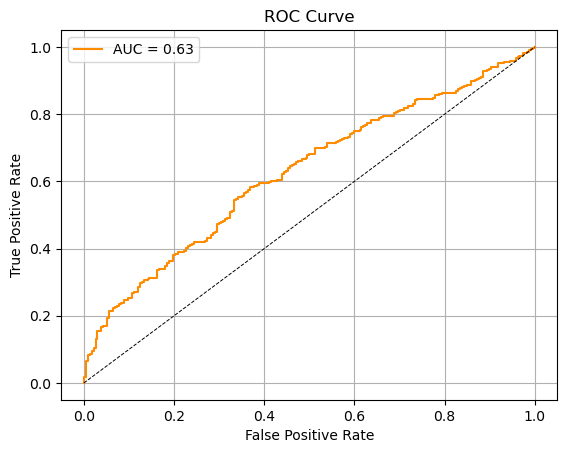

In [181]:
plot_roc_curve(y_true, y_scores)

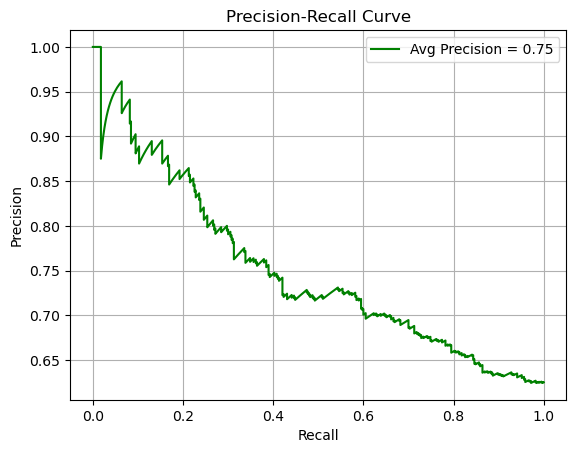

Classification Report:
              precision    recall  f1-score   support

           0     0.4848    0.2735    0.3497       234
           1     0.6545    0.8256    0.7302       390

    accuracy                         0.6186       624
   macro avg     0.5697    0.5496    0.5399       624
weighted avg     0.5909    0.6186    0.5875       624



In [182]:
plot_PR_and_classification_report(y_true, y_pred, y_scores)